In [7]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import sys

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [8]:
data = np.loadtxt(open("./mnist_train_small.csv", "rb"), delimiter=",")


# don't need labels
data = data[:,1:]

# normalize data
dataNorm = data / np.max(data)

# convert to tensor
dataT = torch.tensor(dataNorm).float()

### Create Model

In [9]:
def createNet(n_enc,n_bottle):
    
    class Net(nn.Module):
        
        def __init__(self):
            super().__init__()
            
            ### input layer
            self.input = nn.Linear(784, n_enc)
            
            ### encoder layer
            self.enc = nn.Linear(n_enc, n_bottle)
            
            ### latent layer
            self.lat = nn.Linear(n_bottle, n_enc)
            
            ### decoder layer
            self.dec = nn.Linear(n_enc, 784)
            
        def forward(self, x):
            x = F.relu(self.input(x))
            
            x = F.relu(self.enc(x))
            x = F.relu(self.lat(x))
            y = torch.sigmoid(self.dec(x))
            
            return y
        
    net = Net()
    
    # loss function
    lossFn = nn.MSELoss()
    
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    
    return net, lossFn, optimizer     

In [10]:
# net, lossFn, optimizer = createNet()
# 
# X = dataT[:5,:]
# yHat = net(X)
# 
# print(X.shape)
# print(yHat.shape)

In [11]:
# fig,axs = plt.subplots(2,5,figsize=(10,3))
# 
# for i in range(5):
#     axs[0,i].imshow(X[i,:].view(28,28).detach(), cmap='gray')
#     axs[1,i].imshow(yHat[i,:].view(28,28).detach(), cmap='gray')
#     axs[0,i].set_xticks([]), axs[0,i].set_yticks([]) 
#     axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
#     
# plt.suptitle("Yikes!")
# plt.show()


In [12]:
def function2trainTheModel(n_enc,n_bottle):

  # number of epochs
  numepochs = 5
  
  # create a new model
  net,lossfun,optimizer = createNet(n_enc,n_bottle)

  # initialize losses
  losses = []
  
  # batch size and number of batches
  batchsize = 32
  numBatches = int(dataT.shape[0]/batchsize)
  

  # loop over epochs (each epoch goes through all samples)
  for epochi in range(numepochs):

    # get  permuted index vector
    randidx = np.random.permutation(dataT.shape[0]).astype(int)
    
    batchLosses = []
    
    for batchI in range(numBatches):
        
        ### just for challenge
        # non-overlapping blocks of ints 
        sampsToUse = range((batchI - 1)*batchsize,batchI*batchsize)
        
        # select those images
        X = dataT[randidx[sampsToUse],:]
        
        # forward pass and loss
        ### normally second parameter is yHat but in this case it's not.
        yHat = net(X)
        loss = lossfun(yHat,X)
    
        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        # losses in this epoch
        batchLosses.append( loss.item() )
        # end epoch loop
        
    losses.append( np.mean(batchLosses) )
  

  # function output
  return losses,net

## Running Experiments

In [13]:
### NOTE: this cell takes ~10mins with init N settings

N_encdec_units = np.linspace(10,500,12).astype(int)
N_bottle_units = np.linspace(5,100,8).astype(int)

# init result matrix
exp_results = np.zeros((len(N_encdec_units),len(N_bottle_units)))

for eI,nenc in enumerate(N_encdec_units):
    for bI,nbottle in enumerate(N_bottle_units):
        
        losses = function2trainTheModel(nenc,nbottle)[0] #only loss
        exp_results[eI,bI] = np.mean(losses[-3:])
        
        # send update messages
        currentIter = eI*len(N_bottle_units)+bI+1
        totalIters = len(N_bottle_units)*len(N_encdec_units)
        msg = "Finished experiment {}/{}".format(currentIter,totalIters)
        sys.stdout.write('\r' + msg)

Finished experiment 96/96

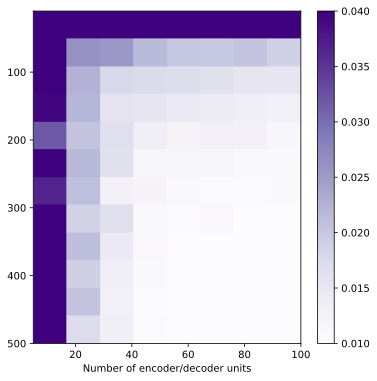

In [14]:
fig = plt.figure(figsize=(6,6))

plt.imshow(exp_results,aspect='auto',
           vmin=.01,vmax=.04,cmap="Purples",
           extent=(N_bottle_units[0],N_bottle_units[-1],N_encdec_units[-1],N_encdec_units[0]))

plt.xlabel("Number of bottleneck units")
plt.xlabel("Number of encoder/decoder units")
plt.colorbar()

plt.show()

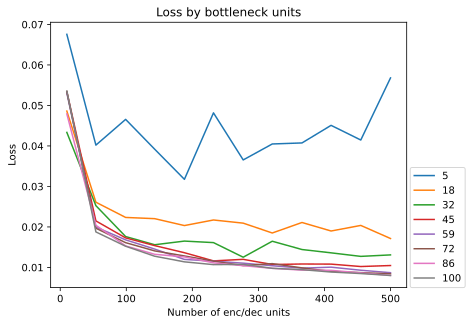

In [15]:
# plot line for better reveal

plt.plot(N_encdec_units,exp_results)
plt.legend(N_bottle_units,loc=(1.01,0))
plt.xlabel("Number of enc/dec units")
plt.title("Loss by bottleneck units")
plt.ylabel("Loss")
plt.show()